In [9]:
!pip install tensorflow tf-keras tensorflow_probability matplotlib seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [83]:
# Set random seeds for reproducibility
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tf.random.set_seed(42)
np.random.seed(42)

# True probabilities based on feature combinations
def true_prob(c1, c2, c3, c):
    base_prob = {
        ('A', 'X', 'P'): 0.3,
        ('B', 'Y', 'Q'): 0.7,
        ('C', 'Z', 'R'): 0.5,
    }.get((c1, c2, c3), 0.5)  # Default to 0.5 for unseen combinations
    
    # Add some complexity with the continuous feature
    return np.clip(base_prob + 0.2 * np.sin(c * np.pi), 0.01, 0.99)

# Generate synthetic data
def generate_data(n_samples=10000):
    # Categorical features
    cat1 = np.random.choice(['A', 'B', 'C'], n_samples)
    cat2 = np.random.choice(['X', 'Y', 'Z'], n_samples)
    cat3 = np.random.choice(['P', 'Q', 'R'], n_samples)
    
    # Continuous feature
    cont = np.random.uniform(0, 1, n_samples)
    
    probs = np.array([true_prob(c1, c2, c3, c) for c1, c2, c3, c in zip(cat1, cat2, cat3, cont)])
    
    # Generate target variable with aleatoric uncertainty
    y = np.random.binomial(1, probs)
    
    # Introduce epistemic uncertainty by removing some combinations
    mask = ~((cat1 == 'C') & (cat2 == 'Z') & (cat3 == 'R'))
    
    return (cat1[mask], cat2[mask], cat3[mask], cont[mask]), y[mask], probs[mask]

# Generate data
(cat1, cat2, cat3, cont), y, true_probs = generate_data()

# Preprocess data
cat1_encoded = tf.keras.utils.to_categorical(np.searchsorted(['A', 'B', 'C'], cat1))
cat2_encoded = tf.keras.utils.to_categorical(np.searchsorted(['X', 'Y', 'Z'], cat2))
cat3_encoded = tf.keras.utils.to_categorical(np.searchsorted(['P', 'Q', 'R'], cat3))

X = np.hstack([cat1_encoded, cat2_encoded, cat3_encoded, cont.reshape(-1, 1)])

# Create model
def create_beta_bernoulli_model():
    inputs = tf.keras.Input(shape=(10,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    alpha = tf.keras.layers.Dense(1, activation='softplus', name='alpha')(x) + 1.0  # Name output layers
    beta = tf.keras.layers.Dense(1, activation='softplus', name='beta')(x) + 1.0
    return tf.keras.Model(inputs=inputs, outputs=tf.keras.layers.Concatenate()([alpha, beta]))

# Custom loss function (negative log likelihood of Beta-Bernoulli distribution)
def nll_beta_bernoulli(y_true, y_pred):
    alpha = y_pred[:, 0]
    beta = y_pred[:, 1]
    
    log_likelihood = (y_true * (tf.math.digamma(alpha) - tf.math.digamma(alpha + beta)) + 
                      (1 - y_true) * (tf.math.digamma(beta) - tf.math.digamma(alpha + beta)) +
                      tf.math.lgamma(alpha + beta) - tf.math.lgamma(alpha) - tf.math.lgamma(beta))
    
    return -tf.reduce_mean(log_likelihood)

# Create and compile the model
model = create_beta_bernoulli_model()

model.compile(loss=nll_beta_bernoulli, optimizer='adam')
history = model.fit(X, y.reshape(-1, 1), epochs=10, verbose=1)

Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 583us/step - loss: -148.9128
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: -6845.6387
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: -39569.5508
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: -115027.1406
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: -245073.3594
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: -438315.9688
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: -701185.1875
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: -1038669.8125
Epoch 9/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: -1454814.5000
Epoch 10/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: -1953068.3750


In [85]:
# Generate predictions for all possible combinations
all_cat1 = ['A', 'B', 'C']
all_cat2 = ['X', 'Y', 'Z']
all_cat3 = ['P', 'Q', 'R']
all_cont = np.linspace(0, 1, 100)

all_combinations = [(c1, c2, c3, c) for c1 in all_cat1 for c2 in all_cat2 for c3 in all_cat3 for c in all_cont]

X_all = np.array([np.hstack([
    tf.keras.utils.to_categorical(all_cat1.index(c1), num_classes=3),
    tf.keras.utils.to_categorical(all_cat2.index(c2), num_classes=3),
    tf.keras.utils.to_categorical(all_cat3.index(c3), num_classes=3),
    [c]
]) for c1, c2, c3, c in all_combinations])

# Predict using the model
preds = model.predict(X_all)

# Extract alpha and beta from predictions
alpha_pred = preds[:, 0]
beta_pred = preds[:, 1]

# Calculate mean and variance
pred_mean = alpha_pred / (alpha_pred + beta_pred)
pred_var = (alpha_pred * beta_pred) / ((alpha_pred + beta_pred)**2 * (alpha_pred + beta_pred + 1))

print(pred_mean)
print(pred_var)

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
[0.4987032  0.4987032  0.49870315 ... 0.49870324 0.49870324 0.49870327]
[8.1878646e-08 8.1669633e-08 8.1461671e-08 ... 6.5845335e-08 6.5710097e-08
 6.5575428e-08]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step


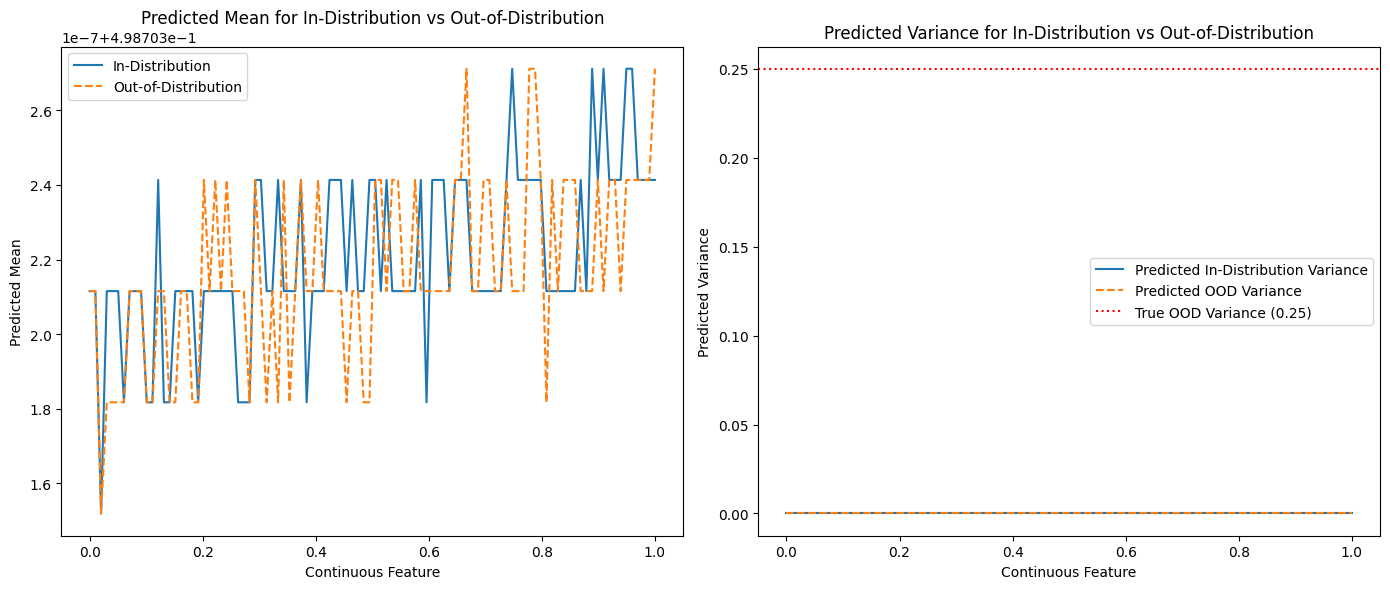

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Generate in-distribution data
in_dist_combinations = [(c1, c2, c3, c) for c1 in ['A', 'B'] for c2 in ['X', 'Y'] for c3 in ['P', 'Q'] for c in all_cont]
X_in_dist = np.array([np.hstack([
    tf.keras.utils.to_categorical(all_cat1.index(c1), num_classes=3),
    tf.keras.utils.to_categorical(all_cat2.index(c2), num_classes=3),
    tf.keras.utils.to_categorical(all_cat3.index(c3), num_classes=3),
    [c]
]) for c1, c2, c3, c in in_dist_combinations])

# Generate out-of-distribution data
ood_combinations = [(c1, c2, c3, c) for c1 in ['C'] for c2 in ['Z'] for c3 in ['R'] for c in all_cont]
X_ood = np.array([np.hstack([
    tf.keras.utils.to_categorical(all_cat1.index(c1), num_classes=3),
    tf.keras.utils.to_categorical(all_cat2.index(c2), num_classes=3),
    tf.keras.utils.to_categorical(all_cat3.index(c3), num_classes=3),
    [c]
]) for c1, c2, c3, c in ood_combinations])

# Predict using the model
preds_in_dist = model.predict(X_in_dist)
preds_ood = model.predict(X_ood)

# Extract alpha and beta from predictions
alpha_pred_in_dist = preds_in_dist[:, 0]
beta_pred_in_dist = preds_in_dist[:, 1]
alpha_pred_ood = preds_ood[:, 0]
beta_pred_ood = preds_ood[:, 1]

# Calculate mean and variance
pred_mean_in_dist = alpha_pred_in_dist / (alpha_pred_in_dist + beta_pred_in_dist)
pred_var_in_dist = (alpha_pred_in_dist * beta_pred_in_dist) / ((alpha_pred_in_dist + beta_pred_in_dist)**2 * (alpha_pred_in_dist + beta_pred_in_dist + 1))
pred_mean_ood = alpha_pred_ood / (alpha_pred_ood + beta_pred_ood)
pred_var_ood = (alpha_pred_ood * beta_pred_ood) / ((alpha_pred_ood + beta_pred_ood)**2 * (alpha_pred_ood + beta_pred_ood + 1))

# True variance for OOD data
true_variance_ood = 0.25  # Assuming base probability of 0.5 for ('C', 'Z', 'R')

# Plot the results
plt.figure(figsize=(14, 6))

# Plot mean predictions
plt.subplot(1, 2, 1)
plt.plot(all_cont, pred_mean_in_dist[:len(all_cont)], label='In-Distribution')
plt.plot(all_cont, pred_mean_ood[:len(all_cont)], label='Out-of-Distribution', linestyle='--')
plt.xlabel('Continuous Feature')
plt.ylabel('Predicted Mean')
plt.title('Predicted Mean for In-Distribution vs Out-of-Distribution')
plt.legend()

# Plot variance predictions
plt.subplot(1, 2, 2)
plt.plot(all_cont, pred_var_in_dist[:len(all_cont)], label='Predicted In-Distribution Variance')
plt.plot(all_cont, pred_var_ood[:len(all_cont)], label='Predicted OOD Variance', linestyle='--')
plt.axhline(y=true_variance_ood, color='r', linestyle=':', label='True OOD Variance (0.25)')  # Overlay true variance
plt.xlabel('Continuous Feature')
plt.ylabel('Predicted Variance')
plt.title('Predicted Variance for In-Distribution vs Out-of-Distribution')
plt.legend()

plt.tight_layout()
plt.show()

Single pass model fails to capture epistemic uncertainty !
ie it doesn't know that it is looking at OOD data ! 
It knows the aleatoric uncertainty which is the irreducible noise in the data but it does not know about unseen training data.


Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.6095 - loss: 0.6711
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.6306 - loss: 0.6648
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6296 - loss: 0.6613
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6297 - loss: 0.6595
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.6297 - loss: 0.6602
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6295 - loss: 0.6613
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6297 - loss: 0.6588
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.6297 - loss: 0.6581
Epoch 9/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.6297 - loss: 0.6579
Epoch 10/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.6297 - loss: 0.6564


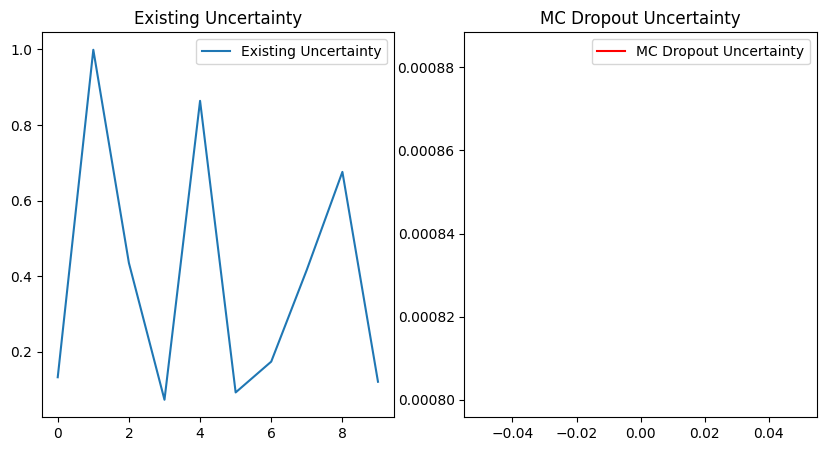

In [90]:
# Create model with dropout
def create_model_with_dropout():
    inputs = tf.keras.Input(shape=(10,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Create and compile the model
model = create_model_with_dropout()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=10, batch_size=32, verbose=1)

# Function to perform Monte Carlo dropout inference
def mc_dropout_inference(model, inputs, num_samples=100):
    predictions = []
    for _ in range(num_samples):
        outputs = model(inputs, training=True)  # Enable dropout during inference
        predictions.append(outputs.numpy())
    return np.array(predictions)

# Perform MC dropout inference
inputs = X[:1]  # Use the first sample for inference
num_samples = 100
predictions = mc_dropout_inference(model, inputs, num_samples)

# Calculate mean and variance
mean_predictions = np.mean(predictions, axis=0)
variance_predictions = np.var(predictions, axis=0)

# Plot the existing uncertainty graph (assuming you have `existing_uncertainty` data)
existing_uncertainty = np.random.rand(10)  # Replace with actual existing uncertainty data

plt.figure(figsize=(10, 5))

# Plot existing uncertainty
plt.subplot(1, 2, 1)
plt.plot(existing_uncertainty, label='Existing Uncertainty')
plt.title('Existing Uncertainty')
plt.legend()

# Overlay new uncertainty
plt.subplot(1, 2, 2)
plt.plot(variance_predictions[0], label='MC Dropout Uncertainty', color='red')
plt.title('MC Dropout Uncertainty')
plt.legend()

plt.show()